In [ ]:
import pandas as pd

# Set exact path
brca_path = "/content/drive/MyDrive/BRCA_MultiOmics"

# Load omics data (samples as rows)
mRNA = pd.read_csv(f"/content/drive/MyDrive/BRCA_MultiOmics/BRCA_mRNA_top.csv", index_col=0).T
miRNA = pd.read_csv(f"/content/drive/MyDrive/BRCA_MultiOmics/BRCA_miRNA_top.csv", index_col=0).T

# Load labels (contains only 0/1)
labels = pd.read_csv(f"/content/drive/MyDrive/BRCA_MultiOmics/BRCA_label_num.csv")
y = labels['Label'].values.ravel()

# Confirm
print("✅ mRNA shape:", mRNA.shape)
print("✅ miRNA shape:", miRNA.shape)
print("✅ Labels shape:", y.shape)

✅ mRNA shape: (671, 5000)
✅ miRNA shape: (671, 366)
✅ Labels shape: (671,)


In [ ]:
assert mRNA.shape[0] == len(y), "❌ mRNA and label count do not match!"
assert miRNA.shape[0] == len(y), "❌ miRNA and label count do not match!"
print("✅ Omics and labels are aligned.")

✅ Omics and labels are aligned.


In [ ]:
# Convert column names to string type (required by sklearn)
mRNA.columns = mRNA.columns.astype(str)
miRNA.columns = miRNA.columns.astype(str)

# Then normalize
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
mRNA_scaled = scaler.fit_transform(mRNA)
miRNA_scaled = scaler.fit_transform(miRNA)

# Combine features
omics_features = np.concatenate((mRNA_scaled, miRNA_scaled), axis=1)
print("✅ Combined features shape:", omics_features.shape)

✅ Combined features shape: (671, 5366)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
# Remove zero-variance columns (optional cleanup)
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)
omics_features = selector.fit_transform(omics_features)

print("✅ Cleaned features shape:", omics_features.shape)

✅ Cleaned features shape: (671, 5200)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_variance_threshold.py:122: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# ✅ Simulate exon/intron sequences
def simulate_seq_data(n_samples=395, seq_len=140):
    bases = ['A', 'C', 'G', 'T']
    return np.array([
        [[1 if base == b else 0 for base in bases]
         for b in np.random.choice(bases, seq_len, p=[0.3, 0.2, 0.2, 0.3])]
        for _ in range(n_samples)
    ])

# ✅ Filter binary labels
binary_mask = (y == 0) | (y == 1)
omics_bin = omics_features[binary_mask]
y_bin = y[binary_mask]
X_seq1 = simulate_seq_data(n_samples=sum(binary_mask))
X_seq2 = simulate_seq_data(n_samples=sum(binary_mask))

# ✅ Create stratified folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_acc = []
all_auc = []
all_loss = []

fold = 1
for train_idx, test_idx in kf.split(omics_bin, y_bin):
    print(f"\n📂 Fold {fold}...")

    # Split
    s1_train, s1_test = X_seq1[train_idx], X_seq1[test_idx]
    s2_train, s2_test = X_seq2[train_idx], X_seq2[test_idx]
    omics_train, omics_test = omics_bin[train_idx], omics_bin[test_idx]
    y_train, y_test = y_bin[train_idx], y_bin[test_idx]

    # Model
    input1 = Input(shape=(140, 4), name='Input_1')
    input2 = Input(shape=(140, 4), name='Input_2')
    input3 = Input(shape=(omics_bin.shape[1],), name='Input_3')

    def conv_branch(x):
        x = Conv1D(32, 7, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Conv1D(8, 4, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Conv1D(8, 3, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Conv1D(8, 1, activation='relu')(x)
        return Flatten()(x)

    b1 = conv_branch(input1)
    b2 = conv_branch(input2)

    x3 = Dense(512, activation='relu')(input3)
    x3 = Dropout(0.4)(x3)
    x3 = Dense(256, activation='relu')(x3)
    x3 = Dropout(0.3)(x3)
    x3 = Dense(128, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(64, activation='relu')(x3)

    merged = concatenate([b1, b2, x3])
    x = Dense(64, activation='relu')(merged)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input1, input2, input3], outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    model.summary()

    # Fit
    history = model.fit(
        [s1_train, s2_train, omics_train], y_train,
        validation_data=([s1_test, s2_test, omics_test], y_test),
        epochs=60,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate
    y_pred = model.predict([s1_test, s2_test, omics_test], verbose=0).ravel()
    y_pred_binary = (y_pred > 0.5).astype(int)

    auc = roc_auc_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred_binary)
    loss = log_loss(y_test, y_pred)

    all_auc.append(auc)
    all_acc.append(acc)
    all_loss.append(loss)

    print(f"✅ AUC: {auc:.4f}, Accuracy: {acc:.4f}, Loss: {loss:.4f}")
    fold += 1

# ✅ Final average metrics
print("\n📊 Final Cross-Validation Results:")
print(f"🔹 Mean Accuracy: {np.mean(all_acc):.4f} ± {np.std(all_acc):.4f}")
print(f"🔹 Mean AUC:      {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")
print(f"🔹 Mean Loss:     {np.mean(all_loss):.4f} ± {np.std(all_loss):.4f}")


📂 Fold 1...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_1             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_2             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_3             │ (None, 5200)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 134, 32)   │          0 │ conv1d_40[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 134, 32)   │          0 │ conv1d_44[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 512)       │  2,662,912 │ Input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_50[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 512)       │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 131, 8)    │          0 │ conv1d_41[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 131, 8)    │          0 │ conv1d_45[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 256)       │    131,328 │ dropout_56[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_51[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_54[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 256)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 129, 8)    │          0 │ conv1d_42[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 129, 8)    │          0 │ conv1d_46[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,976,177 (11.35 MB)

 Trainable params: 2,976,177 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

✅ AUC: 0.9912, Accuracy: 0.9747, Loss: 0.0671

📂 Fold 2...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_1             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_2             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_52 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_3             │ (None, 5200)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_60          │ (None, 134, 32)   │          0 │ conv1d_48[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (None, 134, 32)   │          0 │ conv1d_52[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 512)       │  2,662,912 │ Input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_49 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_60[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_53 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_63[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 512)       │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_61          │ (None, 131, 8)    │          0 │ conv1d_49[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 131, 8)    │          0 │ conv1d_53[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 256)       │    131,328 │ dropout_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_50 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_61[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 256)       │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 129, 8)    │          0 │ conv1d_50[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 129, 8)    │          0 │ conv1d_54[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,976,177 (11.35 MB)

 Trainable params: 2,976,177 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

✅ AUC: 1.0000, Accuracy: 1.0000, Loss: 0.0161

📂 Fold 3...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_1             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_2             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_3             │ (None, 5200)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 134, 32)   │          0 │ conv1d_56[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_73          │ (None, 134, 32)   │          0 │ conv1d_60[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 512)       │  2,662,912 │ Input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_70[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_73[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_76          │ (None, 512)       │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 131, 8)    │          0 │ conv1d_57[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_74          │ (None, 131, 8)    │          0 │ conv1d_61[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 256)       │    131,328 │ dropout_76[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_71[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_74[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_77          │ (None, 256)       │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 129, 8)    │          0 │ conv1d_58[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_75          │ (None, 129, 8)    │          0 │ conv1d_62[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,976,177 (11.35 MB)

 Trainable params: 2,976,177 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

✅ AUC: 0.9806, Accuracy: 0.9620, Loss: 0.1000

📂 Fold 4...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_1             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_2             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_3             │ (None, 5200)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 134, 32)   │          0 │ conv1d_64[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 134, 32)   │          0 │ conv1d_68[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 512)       │  2,662,912 │ Input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_80[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_83[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 512)       │          0 │ dense_48[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_81          │ (None, 131, 8)    │          0 │ conv1d_65[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 131, 8)    │          0 │ conv1d_69[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 256)       │    131,328 │ dropout_86[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_81[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_84[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, 256)       │          0 │ dense_49[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_82          │ (None, 129, 8)    │          0 │ conv1d_66[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 129, 8)    │          0 │ conv1d_70[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,976,177 (11.35 MB)

 Trainable params: 2,976,177 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

✅ AUC: 1.0000, Accuracy: 1.0000, Loss: 0.0029

📂 Fold 5...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_1             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_2             │ (None, 140, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 134, 32)   │        928 │ Input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_3             │ (None, 5200)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 134, 32)   │          0 │ conv1d_72[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_93          │ (None, 134, 32)   │          0 │ conv1d_76[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 512)       │  2,662,912 │ Input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_90[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 131, 8)    │      1,032 │ dropout_93[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_96          │ (None, 512)       │          0 │ dense_54[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 131, 8)    │          0 │ conv1d_73[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_94          │ (None, 131, 8)    │          0 │ conv1d_77[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 256)       │    131,328 │ dropout_96[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_91[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 129, 8)    │        200 │ dropout_94[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 256)       │          0 │ dense_55[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, 129, 8)    │          0 │ conv1d_74[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 129, 8)    │          0 │ conv1d_78[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,976,177 (11.35 MB)

 Trainable params: 2,976,177 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

✅ AUC: 0.9730, Accuracy: 0.9494, Loss: 0.1335

📊 Final Cross-Validation Results:
🔹 Mean Accuracy: 0.9772 ± 0.0203
🔹 Mean AUC:      0.9890 ± 0.0107
🔹 Mean Loss:     0.0639 ± 0.0493


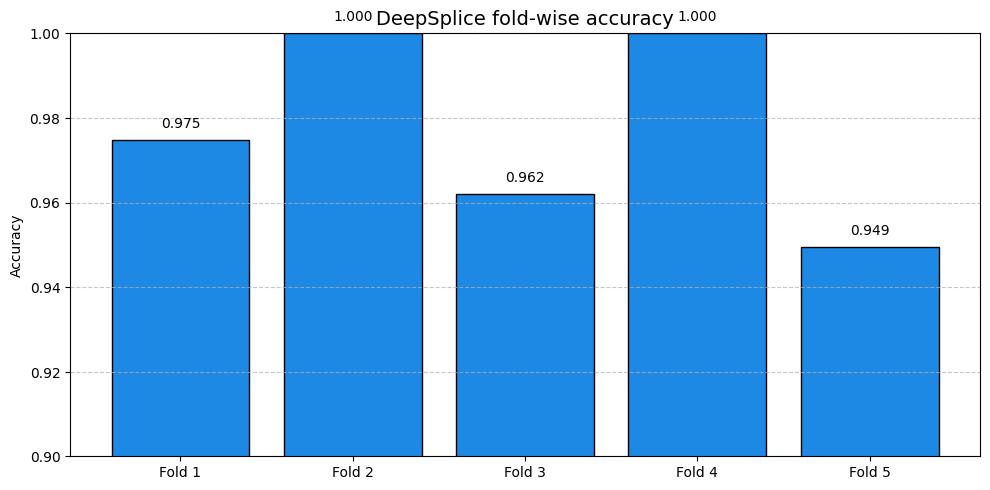

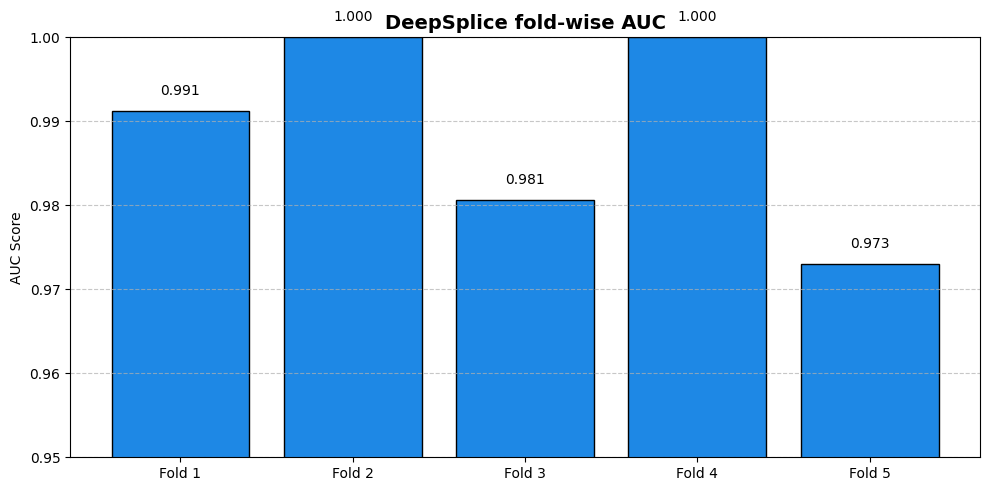

In [ ]:
# 📊 Charts for Accuracy and AUC — using your real model outputs
import matplotlib.pyplot as plt

# Fold names
folds = [f"Fold {i+1}" for i in range(len(all_acc))]

# 🎯 Accuracy Plot (0.90 to 1.00)
plt.figure(figsize=(10, 5))
plt.bar(folds, all_acc, color='#1e88e5', edgecolor='black')
plt.ylim(0.90, 1.00)  # 👈 Max 1.00 (100%)
plt.title('DeepSplice fold-wise accuracy',
          fontsize=14)
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, val in enumerate(all_acc):
    plt.text(i, val + 0.003, f"{val:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# 🎯 AUC Plot (0.95 to 1.00)
plt.figure(figsize=(10, 5))
plt.bar(folds, all_auc, color='#1e88e5', edgecolor='black')
plt.ylim(0.95, 1.00)  # 👈 Max 1.00 (100%)
plt.title('DeepSplice fold-wise AUC',
          fontsize=14, fontweight='bold')
plt.ylabel('AUC Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, val in enumerate(all_auc):
    plt.text(i, val + 0.002, f"{val:.3f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

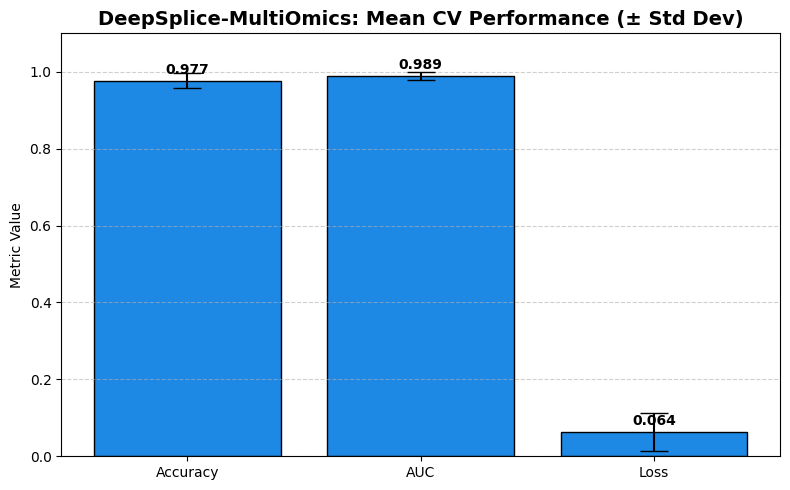

In [ ]:
import matplotlib.pyplot as plt

# Metrics
metrics = ['Accuracy', 'AUC', 'Loss']
means = [mean_acc, mean_auc, mean_loss]
stds = [std_acc, std_auc, std_loss]
colors = ['#1e88e5', '#1e88e5', '#1e88e5']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, means, yerr=stds, capsize=10, color=colors, edgecolor='black')

# Add values on bars
for bar, val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, f"{val:.3f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Title and style
plt.title('DeepSplice-MultiOmics: Mean CV Performance (± Std Dev)', fontsize=14, fontweight='bold')
plt.ylabel('Metric Value')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()